# Fáza 3 - Strojové učenie

In [22]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

In [23]:
connections = pd.read_csv('data/connections.csv', sep='\t')
connections['ts'] = pd.to_datetime(connections['ts'])

processes = pd.read_csv('data/processes.csv', sep='\t')
processes['ts'] = pd.to_datetime(processes['ts'])

conn_processes = pd.merge(connections, processes, on=['ts', 'imei', 'mwra'], how='inner')
conn_processes.drop_duplicates(inplace=True)

Načítanie a spojenie datasetov connections a processes ako v minulej fáze projektu.

In [24]:
X = conn_processes.drop(columns=['mwra'])
y = conn_processes['mwra'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Rozdelenie spojeného datasetu na trénovaciu a testovaciu sadu.

In [25]:
def encode_values(df):
    df['ts'] = df['ts'].astype('int64')
    return df

def remove_attributes(df):
    df = df.drop(['ts', 'imei'], axis=1)
    return df

def fill_missing_values(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    return df

def outlier_replacement(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        lower_bound = df[col].quantile(0.05)
        upper_bound = df[col].quantile(0.95)

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

Funkcie na kódovanie atribútov, odstránenie atribútov, vyplnenia chýbajúcich hodnôt a nahradenia vychýlených hodnôt.

In [26]:
X_train_original = remove_attributes(encode_values(X_train)).to_numpy()
X_test_original = remove_attributes(encode_values(X_test)).to_numpy()

Ponechanie originálnych súborov bez transformácie v tvare numpy array.

In [27]:
encoder_transformer = FunctionTransformer(func=encode_values, validate=False)
removal_transformer = FunctionTransformer(func=remove_attributes, validate=False)
inputer_transformer = FunctionTransformer(func=fill_missing_values, validate=False)
outliers_transformer = FunctionTransformer(func=outlier_replacement, validate=False)

In [28]:
standard_columns = ['c.UCMobile.intl', 'c.updateassist', 'c.UCMobile.x86', 'p.android.defcontainer', 'p.google', 'p.android.gms', 'p.olauncher', 'p.android.vending', 'p.browser.provider', 'p.process.gapps', 'p.gms.persistent', 'p.simulator']
minmax_columns = ['p.android.chrome', 'p.android.documentsui', 'p.android.gm']
power_columns = ['p.notifier']
quantile_columns = ['c.android.gm', 'c.android.youtube', 'c.katana', 'c.dogalize', 'c.android.chrome', 'c.android.vending', 'c.raider', 'p.system', 'p.android.externalstorage', 'p.android.packageinstaller', 'p.android.settings', 'p.inputmethod.latin', 'p.katana', 'p.dogalize']

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('minmax', MinMaxScaler(), minmax_columns),
        ('power', PowerTransformer(method='yeo-johnson'), power_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough'
)

Preprocessor na transformáciu všetkých atribútov pomocou zvolených metód.

In [30]:
pipeline = Pipeline(steps=[
    ('encoding', encoder_transformer),
    ('removing', removal_transformer),
    ('outliers', outliers_transformer),
    ('inputer', inputer_transformer),
    ('preprocessor', preprocessor)
])

In [31]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

Pipeline na predspracovanie údajov pre strojové učenie.

### 3.1 Jednoduchý klasifikátor na základe závislosti v dátach

### (A)

Dáta sme sa rozhodli ešte raz pretransformovať pomocou **KBinsDiscretizer**, nakoľko **ID3 klasifikátor** je nevrhnutý tak, aby pracoval s kategorickými dátami. Keďže náš súbor obsahoval iba numerické dáta, táto transformácia zaručí, že jednotlivé hodnoty budú rozdelené do menšieho počtu skupín. Zvolili sme si 5 skupín a rozdelenie uniform, čo znamená že každá skupina bude mať rovnako veľký rozsah.

In [32]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

X_train_binned = discretizer.fit_transform(X_train_transformed)
X_test_binned = discretizer.transform(X_test_transformed)

##### Klasifikátor
ID3 klasifikátor sme implementovali pomocou triedy s nastaviteľnou maximálnou hĺbkou. Bližšie vysvetlenie ako klasifikátor funguje sa nachádza v komentároch v kóde.

In [33]:
class ID3Classifier:
    def __init__(self, max_depth): # inicializacia stromu s maximalnou hlbkou
        self.max_depth = max_depth
        self.tree = None

    def calculate_entropy(self, y): # vypocet entropie
        _, counts = np.unique(y, return_counts=True) # unikatne hodnoty
        probabilities = counts / len(y)
        
        return -np.sum(probabilities * np.log2(probabilities)) # vzorec na vypocet entropie

    def calculate_information_gain(self, X, y, threshold): # vypocet information gain
        left_mask = X <= threshold # rozdeli, ktore prvky pojdu do lavej a pravej vetvy
        right_mask = ~left_mask
        
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0

        entropy = self.calculate_entropy(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)

        # vzorec na vypocet vazenej entropie (child entropy)
        weighted_entropy = (n_left / len(y)) * self.calculate_entropy(y[left_mask]) + (n_right / len(y)) * self.calculate_entropy(y[right_mask])

        return entropy - weighted_entropy

    def get_best_split(self, X, y): # najde najlepsie miesto na rozdelenie dat
        best_col = None
        best_threshold = None
        best_gain = -1

        for col in range(X.shape[1]): # iteracia cez vsetky atributy
            thresholds = np.unique(X[:, col]) # unikatne hodnoty ako potencialne trasholds
            
            for tr in thresholds:
                gain = self.calculate_information_gain(X[:, col], y, tr)
                
                if gain > best_gain: # priradenie podla najvacsej hodnoty information gain
                    best_col = col
                    best_threshold = tr
                    best_gain = gain

        return best_col, best_threshold

    def get_most_common_class(self, y): # vrati triedu s najvacsim vyskytom
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def build_tree(self, X, y, depth): # funkcia na vytvorenie decision tree
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return self.get_most_common_class(y) # zastavenie rozdelenia

        col, threshold = self.get_best_split(X, y)
        
        if col is None:
            return self.get_most_common_class(y)

        left_mask = X[:, col] <= threshold # rozdelenie dat podla trasholdu
        right_mask = ~left_mask

        return { # vytvori novy node a rekurzivne lavu a pravu stranu
            'feature': col,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def fit(self, X, y): # trenovanie decision tree na zvolenych datach
        self.tree = self.build_tree(X, y, 0)

    def predict_sample(self, sample, tree): # predpoved triedy pre jednu vzorku
        if not isinstance(tree, dict): # ukoncenie ak ide o list
            return tree
        if sample[tree['feature']] <= tree['threshold']: # rozhodnutie ci pokracovat v lavej alebo pravej vetve
            return self.predict_sample(sample, tree['left'])
        else:
            return self.predict_sample(sample, tree['right'])

    def predict(self, X): # predpoved triedy pre vsetky vzorky
        return np.array([self.predict_sample(x, self.tree) for x in X])

Klasifikátor sme implementovali pre maximálnu hĺbku 2 a 5 aby sme videli ako sa menia výsledky s rôznymi hodnotami.

In [34]:
classifier_2 = ID3Classifier(2)

classifier_2.fit(X_train_binned, y_train)
predictions_2 = classifier_2.predict(X_test_binned)

classifier_5 = ID3Classifier(5)

classifier_5.fit(X_train_binned, y_train)
predictions_5 = classifier_5.predict(X_test_binned)

### (B)

In [35]:
def get_id3_results(predictions, depth):
    print(f'\nID3 Classifier results (depth: {depth})')
    
    print('Accuracy:', accuracy_score(y_test, predictions))
    print('Precision:', precision_score(y_test, predictions))
    print('Recall:', recall_score(y_test, predictions))

get_id3_results(predictions_2, 2)
get_id3_results(predictions_5, 5)


ID3 Classifier results (depth: 2)
Accuracy: 0.8020694259012016
Precision: 0.7833629893238434
Recall: 0.9432244242099626

ID3 Classifier results (depth: 5)
Accuracy: 0.8581441922563418
Precision: 0.85205078125
Recall: 0.934654525977504


Výsledky znázorňujú, že klasifikátor s hĺbkou 5 je lepší čo sa týka *accuracy* a *precision*, ale je mierne horší pri *recall*. To znamená, že nemusí byť až tak efektívny pri identifikácii všetkých pozitívnych prípadov. Keďže robíme všeobecnú predikciu, budeme v tomto prípade považovať model s hĺbkou 5 ako efektívnejší. 

### (C)

In [36]:
predictions_5_train = classifier_5.predict(X_train_binned)

print('Training Accuracy:', accuracy_score(y_train, predictions_5_train))
print('Training Precision:', precision_score(y_train, predictions_5_train))
print('Training Recall:', recall_score(y_train, predictions_5_train))

print('\nTest Accuracy:', accuracy_score(y_test, predictions_5))
print('Test Precision:', precision_score(y_test, predictions_5))
print('Test Recall:', recall_score(y_test, predictions_5))

Training Accuracy: 0.8578938584779706
Training Precision: 0.8496511907625691
Training Recall: 0.9397365970466942

Test Accuracy: 0.8581441922563418
Test Precision: 0.85205078125
Test Recall: 0.934654525977504


Klasifikátor nemá overfit. Hodnoty všetkých troch metrík sú veľmi podobné pri predikciách na trénovacích aj testovacích dátach. To naznačuje, že model dobre generalizuje a je schopný správne fungovať aj pri nových dátach.

### 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia

### (A)

In [37]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train_transformed, y_train)
dt_predictions = dt_model.predict(X_test_transformed)

### (B)

In [38]:
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_transformed, y_train)
lr_predictions = lr_model.predict(X_test_transformed)

In [39]:
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions, average='weighted')
dt_recall = recall_score(y_test, dt_predictions, average='weighted')

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
lr_recall = recall_score(y_test, lr_predictions, average='weighted')

print("Výsledky Decision Tree:")
print(f"Accuracy: {dt_accuracy:.4f}, Precision: {dt_precision:.4f}, Recall: {dt_recall:.4f}")
print("\nVýsledky Logistic Regression:")
print(f"Accuracy: {lr_accuracy:.4f}, Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}")

Výsledky Decision Tree:
Accuracy: 0.8788, Precision: 0.8783, Recall: 0.8788

Výsledky Logistic Regression:
Accuracy: 0.8925, Precision: 0.8926, Recall: 0.8925


### (C)

In [40]:
id3_accuracy = accuracy_score(y_test, predictions_5)
id3_precision = precision_score(y_test, predictions_5, average='weighted')
id3_recall = recall_score(y_test, predictions_5, average='weighted')

print("Výsledky ID3 Classifier:")
print(f"Accuracy: {id3_accuracy:.4f}, Precision: {id3_precision:.4f}, Recall: {id3_recall:.4f}")

Výsledky ID3 Classifier:
Accuracy: 0.8581, Precision: 0.8593, Recall: 0.8581


In [41]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Logictic Regresion', 'ID3 Classifier'],
    'Accuracy': [dt_accuracy, lr_accuracy, id3_accuracy],
    'Precision': [dt_precision, lr_precision, id3_precision],
    'Recall': [dt_recall, lr_recall, id3_recall]
})

results.set_index('Model', inplace=True)
results

,Accuracy,Precision,Recall
Model,,,
Decision Tree,0.878838,0.878309,0.878838
Logictic Regresion,0.892523,0.892626,0.892523
ID3 Classifier,0.858144,0.859308,0.858144


### (D)

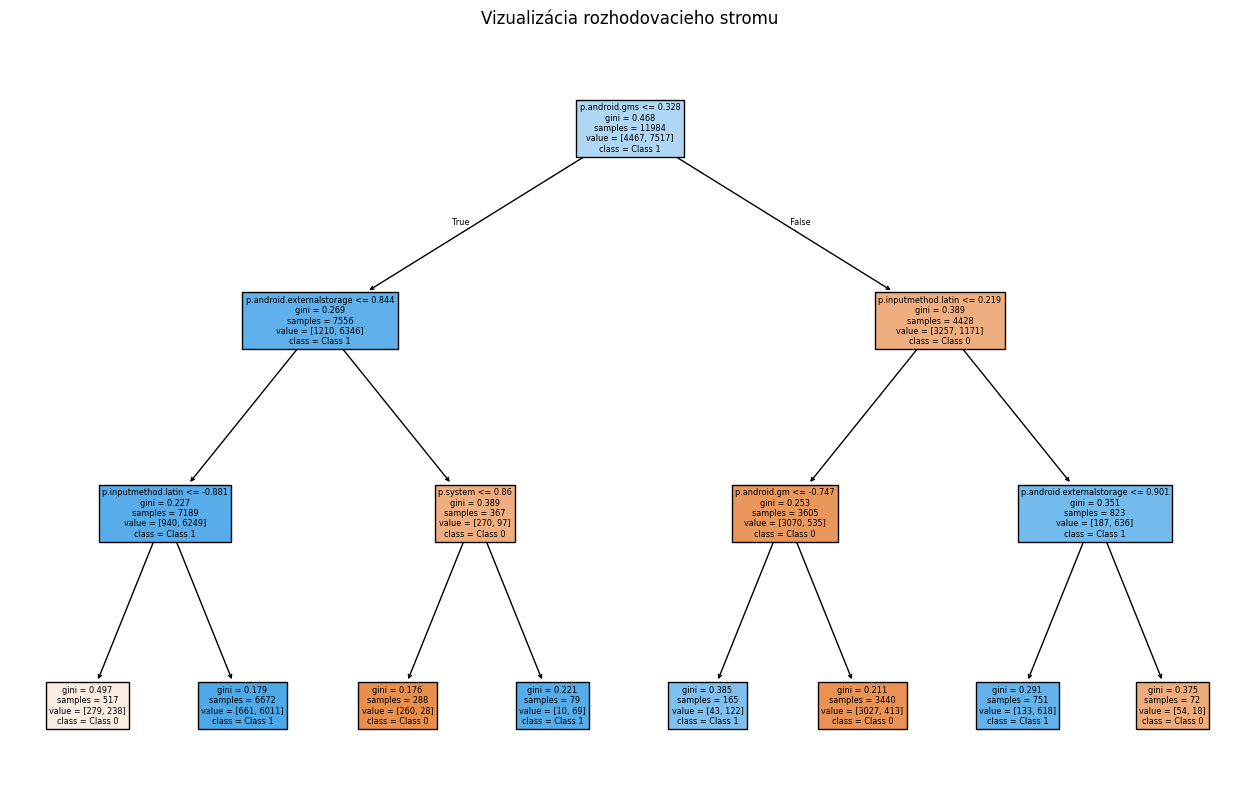

In [42]:
plt.figure(figsize=(16, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.title("Vizualizácia rozhodovacieho stromu")
plt.show()

### (E)

## Hodnotenie modelov pomocou metrík

### Decision Tree Classifier:
- **Accuracy**: 0.8788 (87.88%)  
- **Precision**: 0.8783  
- **Recall**: 0.8788  

Decision Tree Classifier dosiahol vysokú presnosť a vyvážené hodnoty precision a recall. To naznačuje, že model dokáže spoľahlivo identifikovať väčšinu správnych tried, avšak mierne zaostáva za Logistic Regression, čo sa týka predikčnej presnosti.

---

### Logistic Regression:
- **Accuracy**: 0.8922 (89.22%)  
- **Precision**: 0.8923  
- **Recall**: 0.8922  

Logistic Regression prekonal Decision Tree vo všetkých troch hodnotených metrikách. Dosiahol najlepšiu presnosť, čo naznačuje, že má menej nesprávnych predikcií, pričom vysoké hodnoty precision a recall ukazujú na efektívnu detekciu správnych tried a minimálne chyby.

---

### ID3 Classifier:
- **Accuracy**: 0.8588 (85.88%)
- **Precision**: 0.8599  
- **Recall**: 0.8588  

ID3 Classifier dosiahol vyvážené výsledky so zhodnými hodnotami v metrikách. Tento model vykazuje stabilné výkony pri detekcii tried, ale nie je najvýkonnejší. Model môže mať menší priestor na zlepšenie, najmä vzhľadom na jeho jednoduchosť.

### 3.3 Optimalizácia alias hyperparameter tuning

### (A)

### (B)

### (C)

### (D)

### 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### (A)

### (B)

### (C)

### (D)

### (E)